In [ ]:
import sys
import numpy as np
!pip install emcee
import emcee
import astropy.io.fits as pyfits
from astropy.constants import c
import matplotlib.pylab as pl
# Triangle is now called "corner"
!pip install corner
import corner
import random,os
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
from astropy.io import ascii
from scipy.stats import multivariate_normal, norm
import scipy
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
q = -0.55   # Omaga_m = 0.3, Omega_lam = 0.7
c = c.value/1000.

Mounted at /content/drive


**CRB**:  I copied B_all.dat to the CSP shared drive. That was the only way I could "find" it.

**06/24/2021**:  Added new index arrays (w20,w21,w22) for the different calibrators

In [ ]:


tab = ascii.read('drive/Shareddrives/CSP/H0/B_all_nok21.csv') # You just beed this table somewhere in any of your folder !



# single cut

#w2 = np.where(dist>0.) # Calibrators
# An index array for which zero-point to use (0 == distant, 1==cepheid, etc)
w = np.where((tab['sn']!='CSP14abk') &  (tab['sn']!='PTF13dyt') &  (tab['sn']!='PTF13dym') & (tab['sn']!='PTF14yw') & (tab['sn']!='PS1-13eao') & (tab['subtype']!='Ia-SC') & (tab['subtype']!='Ia-02cx') & (tab['sn']!='LSQ14fmg')& (tab['sn']!='SN2004dt')& (tab['sn']!='SN2005gj')& (tab['sn']!='SN2005hk')& (tab['sn']!='SN2006bt')& (tab['sn']!='SN2006ot')& (tab['sn']!='SN2007so')& (tab['sn']!='SN2008ae')& (tab['sn']!='SN2008bd')& (tab['sn']!='SN2008ha')& (tab['sn']!='SN2008J')& (tab['sn']!='SN2009dc')& (tab['sn']!='SN2009J')& (tab['sn']!='SN2010ae'))


st = tab['st'][w]
est = tab['est'][w]
zhel = tab['zhel'][w]
zcmb = tab['zcmb'][w]
mmax = tab['Mmax'][w]
emmax = tab['eMmax'][w]
bv = tab['BV'][w]
ebv = tab['eBV'][w]
m_csp = tab['m'][w]
dist = tab['dist'][w]
edist = tab['edist'][w]
c_ms = tab['covMs'][w]
c_mbv = tab['covBV_M'][w]
methods = tab['caltype'][w]


p0idx = np.zeros(mmax.shape, dtype=int)
p0idx[methods=='c'] = 1
p0idx[methods=='t'] = 2
p0idx[methods=='s'] = 3


In [ ]:
#initial guess
plim=-19.3, -19.2
p1lim =-1.2,-1.1
p2lim=-.055,-0.05
sigcallim = 0.01,0.1
rvlim =2.7,2.71
alphalim=-0.11,-0.1
siglim=0.1,.12
vellim =300.,310
h0lim= 71.0,71.1
sd_callim = .1,.11
alim = .1,.11
blim = .1,.11

In [ ]:
# Eqn 9 of Bruns 2018
def distmod(h,z1,z2):
    t1 = (1+z1)/(1+z2)
    t2 = (c*z2)/h
    t3 = 1 + (((1-q)/2)*z2)
    return (5*np.log10(t1*t2*t3)) +25


**CRB:** Now that we're trying something new, we no longer need this covariance matrix (unless the authors of the calibration papers offer their own). So the calibrator line is just like the distant sample now. In fact, to simplify things, we can combine both likelihoods together and just use w1 and w2 to set the distances correctly... Let me try that...

In [ ]:
# Liklihood function
def like(par):
    p0s = par[0:4]
    sig_cal,p1,p2,rv,alpha,sig,vel,h0 = par[4:]
    if  -25.0<p0s[0]<14.0  and \
        -10.0<p1<10.0 and \
        -10.0<p2<10.0 and \
        0 < sig_cal < 1 and \
        0.<rv<10.0 and \
        -1.<alpha<1. and \
        0.<sig<1. and \
        0.<vel<1000. and \
        0< h0 < 1000.0:  # priors

        mu_obs = mmax - p0s[p0idx] - p1*(st - 1.) -  p2*(st - 1.)**2 - rv*bv - alpha*(m_csp-np.median(m_csp))
        # For distant sample:  Hubble law, for calibrators: the distance.
        mu_model =  np.where(dist < 0, distmod(h0,zhel,zcmb), dist)
        fac= (p1+(2*p2*st))
        # Errors for all SNe
        mu_stat = (fac*est)**2 +emmax**2 +(rv*ebv)**2+2*fac*c_ms+rv*c_mbv+sig**2
        # For distant sample:  error in peculiar velocity. For calibrators:  error in distance
        mu_stat = mu_stat + np.where(dist < 0, (0.00000723*vel/zcmb)**2, edist**2)
        mu_stat = np.sqrt(mu_stat)
        dmu=mu_obs-mu_model
        chi =np.sum((dmu)**2/mu_stat**2)

        lnlike = -0.5*chi - (0.5*np.sum(np.log(2*np.pi*(mu_stat)**2)))



        lnlike += np.sum(norm.logpdf(p0s[1:], loc=p0s[0], scale=sig_cal))
        lnlike += scipy.stats.invgamma.logpdf(sig_cal, a=2, scale=0.2)
        lnlike += -np.log(sig_cal) # Jeffreys prior




        return lnlike
    else:
        return -np.inf


In [ ]:
# EMCEE setup
ndim, nwalkers = 12, 120
ssize=3000
burnin = 1000
p000 = np.random.rand(nwalkers) * (plim[1] - plim[0]) + plim[0]
p010 = np.random.rand(nwalkers) * (plim[1] - plim[0]) + plim[0]
p020 = np.random.rand(nwalkers) * (plim[1] - plim[0]) + plim[0]
p030 = np.random.rand(nwalkers) * (plim[1] - plim[0]) + plim[0]
sigcal0 = np.random.rand(nwalkers) * (sigcallim[1]-sigcallim[0]) + sigcallim[0]
p10 = np.random.rand(nwalkers) * (p1lim[1] - p1lim[0]) + p1lim[0]
p20 = np.random.rand(nwalkers) * (p2lim[1] - p2lim[0]) + p2lim[0]
rv0 = np.random.rand(nwalkers) * (rvlim[1] - rvlim[0]) + rvlim[0]
alpha0 = np.random.rand(nwalkers) * (alphalim[1] - alphalim[0]) + alphalim[0]
sig0 = np.random.rand(nwalkers) * (siglim[1] - siglim[0]) + siglim[0]
vel0 = np.random.rand(nwalkers) * (vellim[1] - vellim[0]) + vellim[0]
h00 = np.random.rand(nwalkers) * (h0lim[1] - h0lim[0]) + h0lim[0]

p0 = np.array([p000,p010,p020,p030,sigcal0,p10,p20,rv0,alpha0,sig0,vel0,h00]).T


In [ ]:
# Sampling
sampler = emcee.EnsembleSampler(nwalkers, ndim, like, pool = Pool())
print ("running mcmc..")
start = time.time()
sampler.run_mcmc(p0,ssize, progress=True)
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
end = time.time()
serial_time = end - start
print ("End of mcmc")
print ("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
print("Serial took {0:.1f} minutes".format(serial_time/60.))


running mcmc..


100%|██████████| 3000/3000 [13:39<00:00,  3.66it/s]

End of mcmc
Mean acceptance fraction: 0.3706333333333333
Serial took 13.7 minutes


Text(0.5, 0, 'step number')

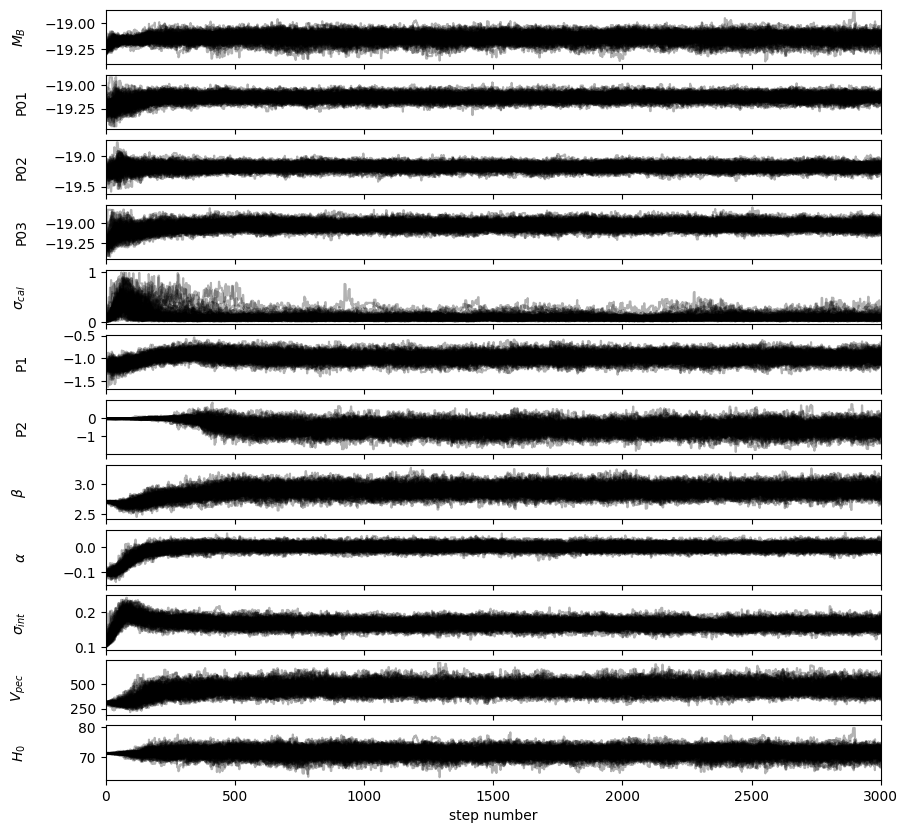

In [ ]:
fig, axes = pl.subplots(12, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ["$M_B$","P01","P02","P03","$\sigma_{cal}$","P1", "P2", r"$\beta$",r"$\alpha$", r"$\sigma_{int}$",r"$V_{pec}$", r"$H_0$"]

for j in range(ndim):
    ax = axes[j]
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

**SAU**: Tried following : https://emcee.readthedocs.io/en/stable/tutorials/line/

In [ ]:
labels=["$P0$","$P01$","$P02$","$P03$","$\sigma_{cal}$","$P1$", "$P2$", r"$\beta$",r"$\alpha$", r"$\sigma_{int}$","$V_{pec}$", r"$H_0$" ]
label=["P0","P01","P02","P03","\sigma_{cal}","P1", "P2", r"\beta",r"\alpha", r"\sigma_{int}","V_{pec}", "H_0" ]


flat_samples = sampler.get_chain(discard=1000, thin=25, flat=True)


from IPython.display import display, Math, Latex
res=[]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}".format(mcmc[1], q[0], q[1], label[i])
    display(Math(txt))
    print(' ')
    res.append(mcmc[1])


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

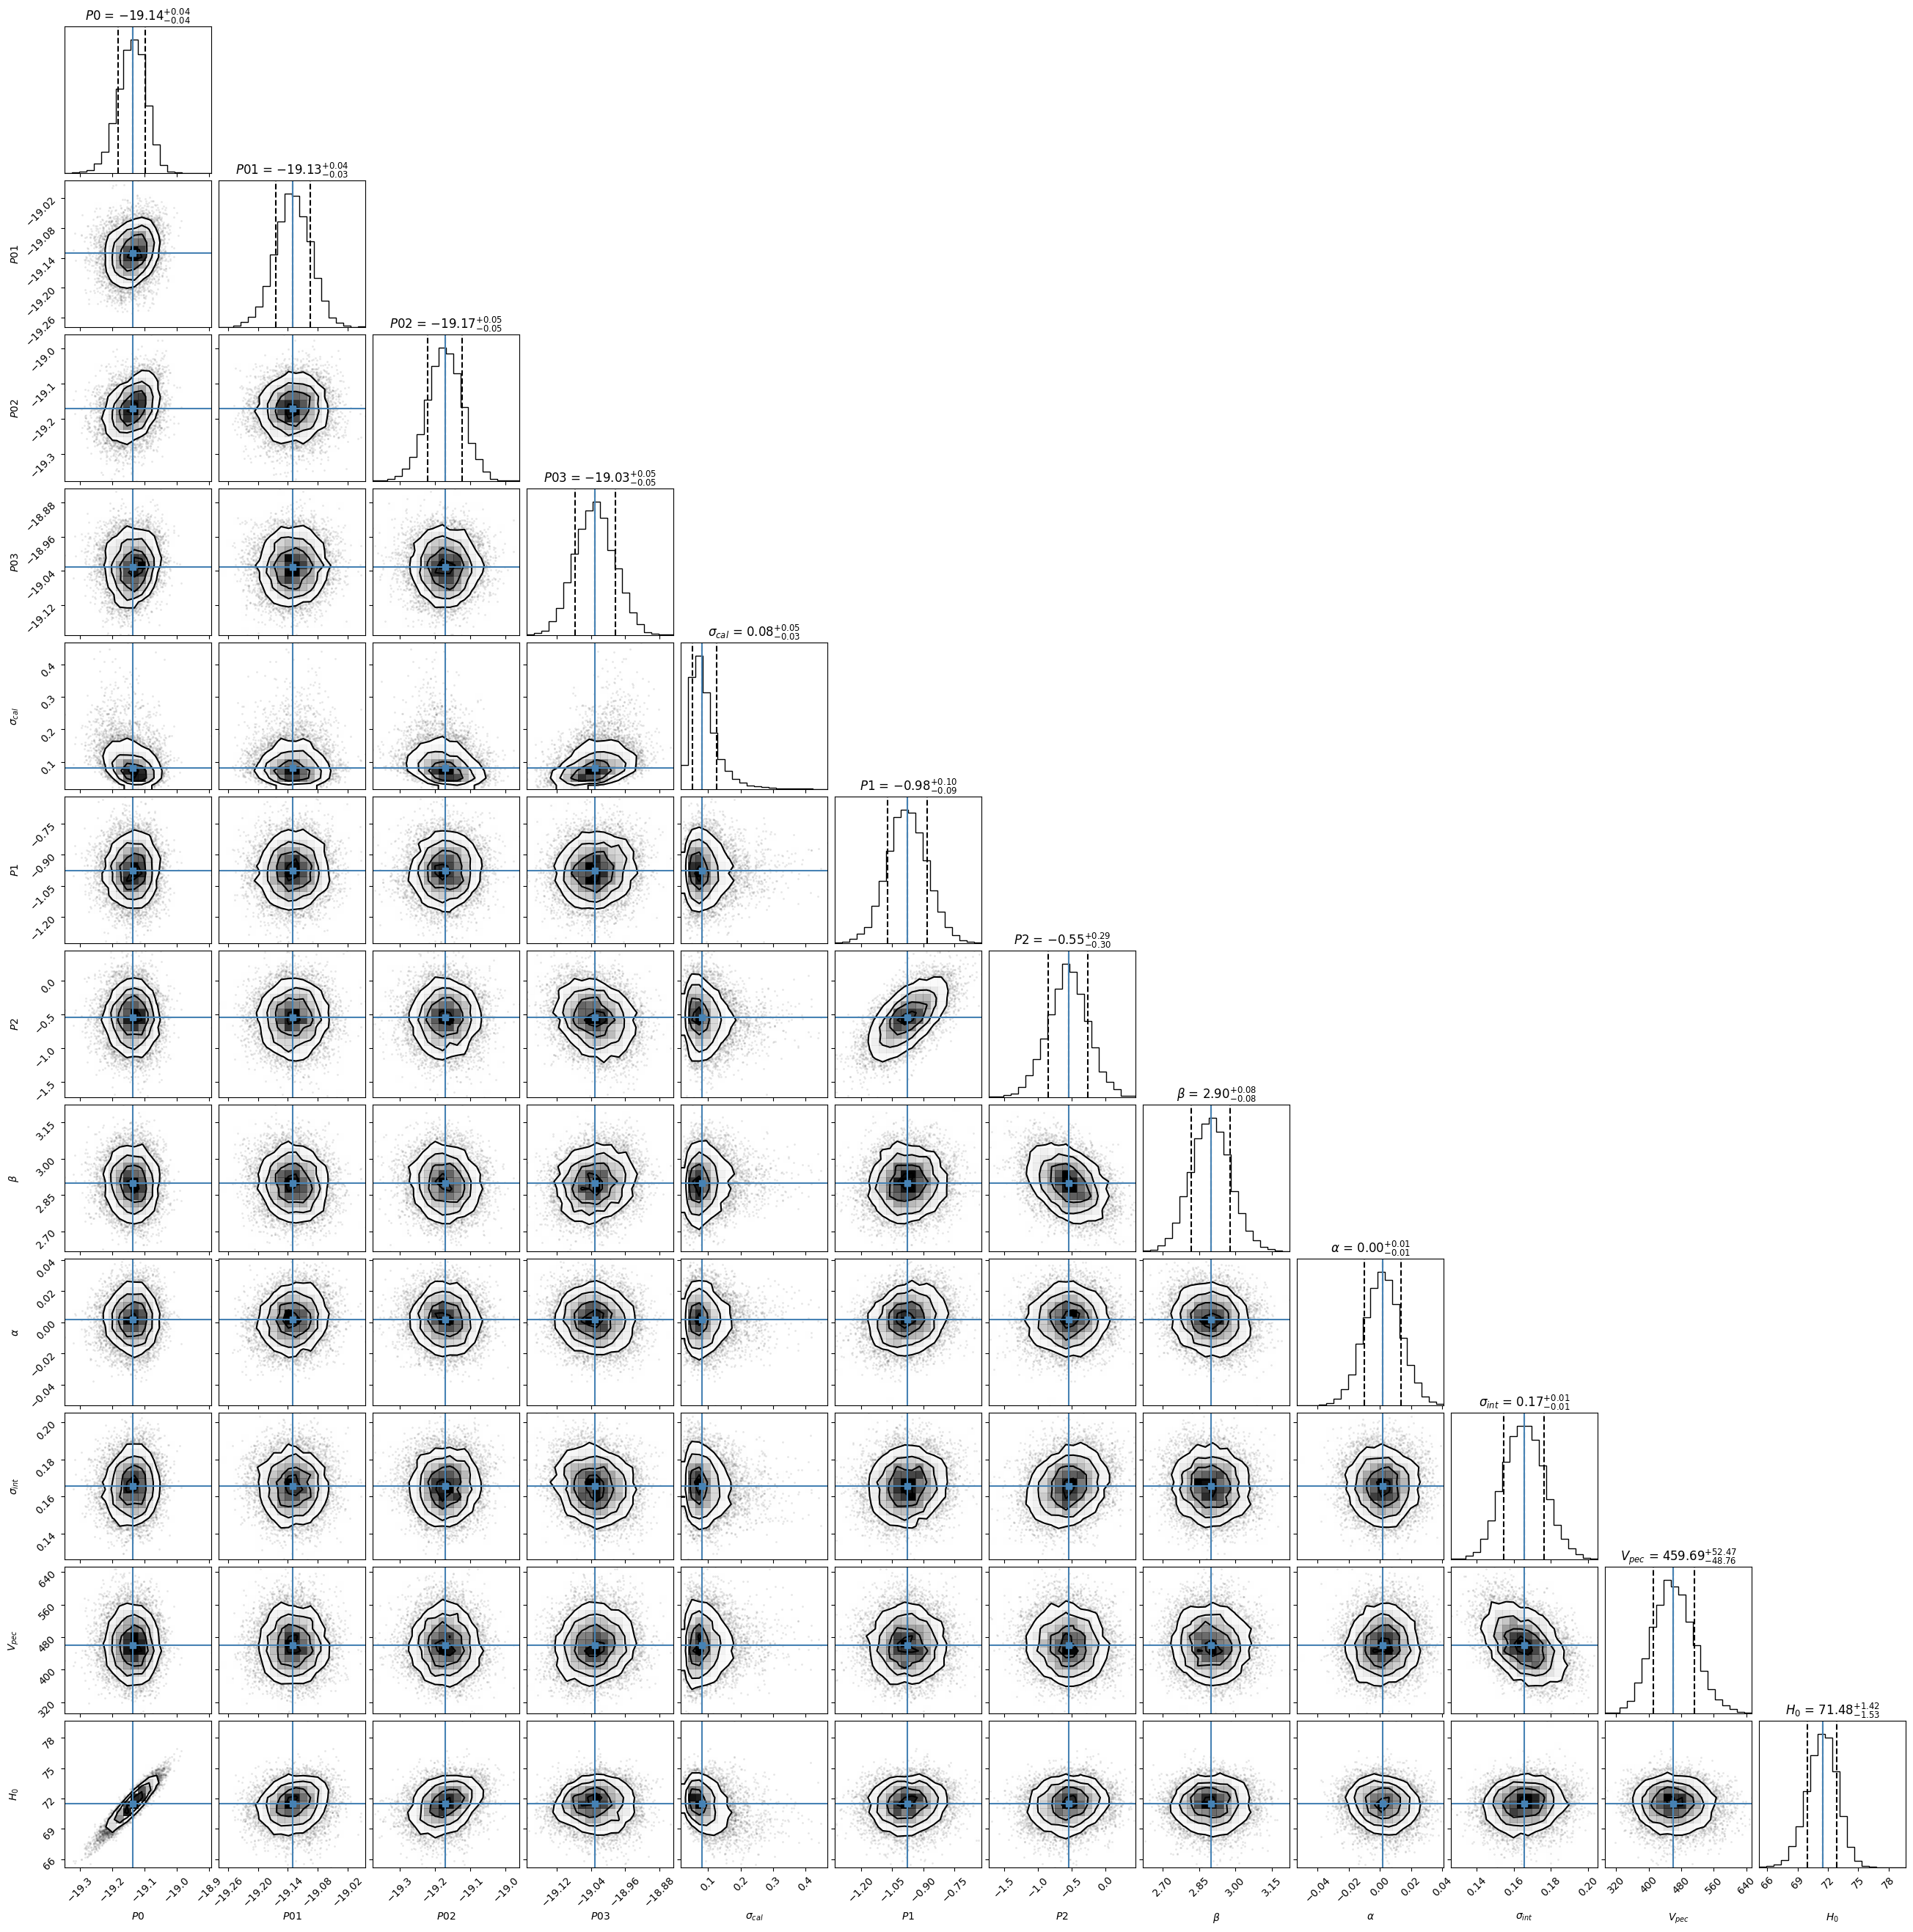

In [ ]:
fig = corner.corner(
    flat_samples, labels=labels, truths=res,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84],show_titles=True
);

In [ ]:
fig.savefig('mcmc_allcalH.pdf')

In [ ]:
from google.colab import files
files.download("mcmc_allcalH_jef.pdf")

FileNotFoundError: ignored